In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install openpyxl
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
!pip install libpysal
!pip install esda
!pip install pysal
from esda.getisord import G_Local
from libpysal.weights import Queen
from matplotlib.colors import SymLogNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm

# Specifications

In [2]:
save = False
optimal_cluster = 'st_cluster_3_5_7'  # Cluster of interest

# Load County-Aggregated Policy Data

In [3]:
# Load aggregated sum policies by state
policies = pd.read_csv("../Local_Data/NFIP_Data/policy_total_county_averages.csv")

# Filter out rows with missing or blank values in the relevant columns
policies = policies.dropna(subset=['countyCode', 'policyCost_mean', 'totalInsurancePremiumOfThePolicy_mean'])
policies['countyCode'] = policies['countyCode'].astype(int).astype(str)
policies['countyCode'] = policies['countyCode'].apply(lambda x: str(x).zfill(5))
policies['oldest_year'] = policies['oldest_year'] -1 
policies['most_recent_year'] = policies['most_recent_year'] -1 

# Load Risk Rating 2.0 Data

In [4]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

## Map Fips to appropriate county

In [5]:
# Read the file line by line
with open('../Local_Data/fips_codes.txt', 'r') as file:
    lines = file.readlines()

# Identify where state-level data starts and ends
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # State data starts after the "state-level" heading
    if "county-level" in line.lower():
        county_section_start = i + 2  # County data starts after the "county-level" heading
        break

# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

# Split the data into sections
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # Skip the header lines
    if "county-level" in line.lower():
        county_section_start = i + 2  # Skip the header lines
        break

state_lines = lines[state_section_start:county_section_start-2]  # State data lines
county_lines = lines[county_section_start:]  # County data line

# Parse county data
county_fips = []
county_name = []

for line in county_lines:
    line = line.strip()
    if len(line) > 12 and line[:5].isdigit():
        county_fips_code = line[:5].strip()
        county_fips_name = line[12:].strip()
        county_fips.append(county_fips_code)
        county_name.append(county_fips_name)

county_df = pd.DataFrame({
    'countyCode': county_fips,
    'County Name': county_name
})

county_df['State FIPS'] = county_df['countyCode'].str[:2]  # Extract state FIPS from the countyCode

# Merge
fips_df = county_df.merge(state_df, on='State FIPS')
fips_df['County Name'] = fips_df['County Name'].str.upper()

In [6]:
# Ensure that County and State names are fully capitalized in the aggregated_risk_policies DataFrame
aggregated_risk_policies['County'] = aggregated_risk_policies['County'].str.upper()
aggregated_risk_policies['State'] = aggregated_risk_policies['State'].str.upper()

# Merge the DataFrames
aggregated_risk_policies = aggregated_risk_policies.merge(fips_df, left_on=['County', 'State'], right_on=['County Name', 'State Name'], how='left')

# Drop unnecessary columns (optional)
aggregated_risk_policies = aggregated_risk_policies.drop(columns=['County Name', 'State Name'])

# Load Clustered Claims Data

In [7]:
# Load claims data
claims = pd.read_csv("clustered_claims_final.csv", low_memory=False)

# Extract Hyperclusters

In [8]:
# Copy claims dataframe
claims_masked = claims.copy()

# Group by 'optimal_cluster' and sort by size
claims_masked = claims_masked[claims_masked[optimal_cluster] != -1]
grouped_clusters = (
    claims_masked.groupby(optimal_cluster)['adjustedClaim']
    .sum()
    .sort_values(ascending=False)
)

# Print the billion-dollar clusters
top_clusters = grouped_clusters[grouped_clusters > 1000000000]
print("Billion-Dollar Clusters:")
print(top_clusters)

# Compute the 99.9th percentile of cluster claim sizes
p999_value = np.percentile(grouped_clusters, 99.9)
print(f"The empirical 99.9th percentile of adjustedClaim is {p999_value:,.2f}.")

# Select clusters whose claim size exceeds that percentile
top_clusters_2 = grouped_clusters[grouped_clusters > p999_value]

# Print the top 99.9% clusters
print("Clusters above the 99.9th percentile:")
print(top_clusters_2)

Billion-Dollar Clusters:
st_cluster_3_5_7
4      2.542497e+10
87     1.166436e+10
327    1.146593e+10
166    4.991470e+09
8      3.649977e+09
295    3.280849e+09
6      2.628407e+09
190    2.410285e+09
312    1.865101e+09
91     1.825452e+09
158    1.424590e+09
342    1.196346e+09
Name: adjustedClaim, dtype: float64
The empirical 99.9th percentile of adjustedClaim is 2,409,739,890.17.
Clusters above the 99.9th percentile:
st_cluster_3_5_7
4      2.542497e+10
87     1.166436e+10
327    1.146593e+10
166    4.991470e+09
8      3.649977e+09
295    3.280849e+09
6      2.628407e+09
190    2.410285e+09
Name: adjustedClaim, dtype: float64


# Find Net Balance Under Current RR2

In [9]:
# Find Current RR2 Annual Total, Written Premium + Federal Policy Fee
annual_RR2_sum = aggregated_risk_policies['Total Written Premium + FPF'].sum()

# Group Claims by 'Year' and calculate the sum of 'adjustedClaim'
grouped_claims = claims.groupby('year')['adjustedClaim'].sum()

# Calculate net balance by year
net_gain = annual_RR2_sum - grouped_claims 

# Mask the datapoints in the billion-dollar clusters
mask = claims_masked[optimal_cluster].isin(top_clusters.index)
masked_claims = claims_masked[~mask]

# Group masked claims by 'Year', sum 'adjustedClaim', and subtract fixed value
grouped_claims_masked = masked_claims.groupby('year')['adjustedClaim'].sum()
adjusted_values = annual_RR2_sum - grouped_claims_masked 

# Mask the datapoints in the top 99.9% clusters
mask_2 = claims_masked[optimal_cluster].isin(top_clusters_2.index)
masked_claims_2 = claims_masked[~mask_2]

# Group masked claims by 'Year', sum 'adjustedClaim', and subtract fixed value
grouped_claims_masked_2 = masked_claims_2.groupby('year')['adjustedClaim'].sum()
adjusted_values_2 = annual_RR2_sum - grouped_claims_masked_2

# Figure 4

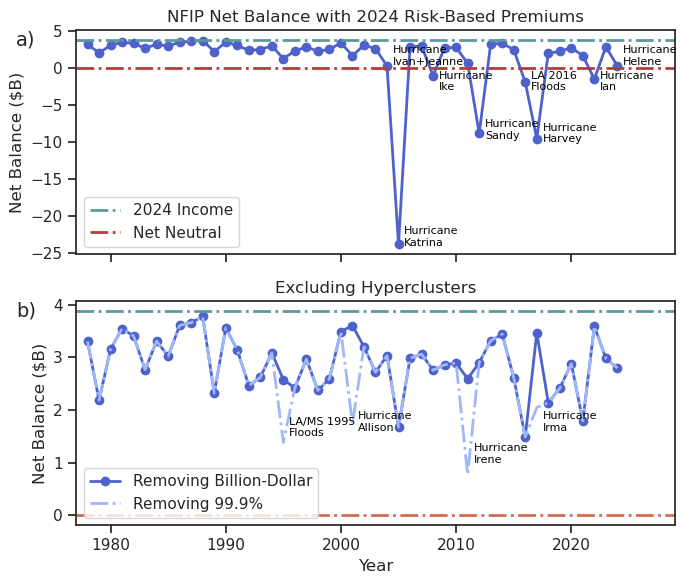

In [10]:
sns.set_theme(style="ticks")  # Ensures Seaborn styles are applied to all plots

# Plot the stacked time series
fig, axes = plt.subplots(2, 1, figsize=(7.08, 6), sharex=True)

# Plot the first time series
axes[0].plot(net_gain.index, net_gain.values/1000000000, marker='o', color='#4F62CC', linewidth=2)
axes[0].axhline(annual_RR2_sum/1000000000, color='#5B999B', linestyle='dashdot', linewidth=2, label='2024 Income')
axes[0].axhline(0, color='#B53D39', linestyle='dashdot', label='Net Neutral', linewidth=2)
axes[0].set_title('NFIP Net Balance with 2024 Risk-Based Premiums')
axes[0].set_ylabel('Net Balance ($B)')
axes[0].legend()
axes[0].text(-0.1, 1, "a)", transform=axes[0].transAxes, fontsize=14, va='top', ha='left')

# Add text labels to the first subplot
annotations = [
    (2004, 0.5, "Hurricane\nIvan+Jeanne"),
    (2005, -24, "Hurricane\nKatrina"),
    (2008, -3, "Hurricane\nIke"),
    (2012, -9.5, "Hurricane\nSandy"),
    (2016, -3, "LA 2016\nFloods"),
    (2017, -10, "Hurricane\nHarvey"),
    (2022, -3, "Hurricane\nIan"),
    (2024, 0.5, "Hurricane\nHelene")
]
for x, y, label in annotations:
    axes[0].text(x + 0.5, y, label, fontsize=8, color='black')

# Plot the second time series
axes[1].plot(adjusted_values.index, adjusted_values.values/1000000000, marker='o', label='Removing Billion-Dollar', color='#4F62CC', linewidth=2)
axes[1].plot(adjusted_values_2.index, adjusted_values_2.values/1000000000, color='#9EB7F9', linestyle='dashdot', label='Removing 99.9%', linewidth=2)
axes[1].axhline(annual_RR2_sum/1000000000, color='#5B999B', linestyle='dashdot', linewidth=2)
axes[1].axhline(0, color='#D06A54', linestyle='dashdot', linewidth=2)
axes[1].set_title('Excluding Hyperclusters')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Net Balance ($B)')
axes[1].set_xlim([1977, 2029])
axes[1].legend()
axes[1].text(-0.1, 1, "b)", transform=axes[1].transAxes, fontsize=14, va='top', ha='left')


# Add text labels to the first subplot
annotations = [
    (1995, 1.5, "LA/MS 1995\nFloods"),
    (2001, 1.6, "Hurricane\nAllison"),
    (2011, 1, "Hurricane\nIrene"),
    (2017, 1.6, "Hurricane\nIrma")
]
for x, y, label in annotations:
    axes[1].text(x + 0.5, y, label, fontsize=8, color='black')

# Adjust layout
plt.tight_layout()
if save:
    output_path='Plots/F4_Time_Series.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')
plt.show()